# Introduction to PFJAX

**Martin Lysy -- University of Waterloo**

**September 1, 2022**

## Summary

The goal of **PFJAX** is to provide tools for estimating the parameters $\tth$ of a [state-space model](http://www.scholarpedia.org/article/State_space_model)

$$
\begin{aligned}
\xx_0 & \sim \pi(\xx_0 \mid \tth) \\
\xx_t & \sim f(\xx_t \mid \xx_{t-1}, \tth) \\
\yy_t & \sim g(\yy_t \mid \xx_t, \tth).
\end{aligned}
$$

In such models, only the *measurement variables* $\yy_{0:T} = (\yy_0, \ldots, \yy_T)$ are observed, whereas the *state variables* $\xx_{0:T}$ are latent.  The marginal likelihood given the observed data is

$$
\begin{aligned}
\Ell(\tth) & = p(\yy_{0:T} \mid \tth) \\
& = \int \pi(\xx_0 \mid \tth) \times \prod_{t=0}^T g(\yy_t \mid \xx_t, \tth) \times \prod_{t=1}^T f(\xx_t \mid \xx_{t-1}, \tth) \ud \xx_{0:T},   
\end{aligned}
$$

but this integral is typically intractable.  The state-of-the-art for approximating it is via [particle filtering methods](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/johansen/publications/dj11.pdf).  **PFJAX** provides several particle filters to estimate the marginal loglikelihood $\ell(\tth) = \log \Ell(\tth)$, along with its gradient $\nabla \ell(\tth) = \frac{\partial}{\partial \tth} \ell(\tth)$ and hessian $\nabla^2 \ell(\tth) = \frac{\partial^2}{\partial \tth \partial \tth'} \ell(\tth)$.  To do this efficiently, **PFJAX** uses JIT-compilation and automatic differentiation as provided by the [**JAX**](https://github.com/google/jax) library.

In this tutorial, we'll show how to use **PFJAX** to:

- Create a state-space model class inheriting from `pfjax.BaseModel`.

- Use this class to simulate data this state-space model via `pfjax.simulate()`.

- Use a basic particle filter `pfjax.particle_filter()` to estimate the marginal loglikelihood $\ell(\tth)$.


<!-- - Simulate data from a state space model and estimate its marginal loglikelihood $\ell(\tth)$.

- Approximate the maximum likelihood estimator $\hat \tth = \argmax_{\tth} \ell(\tth)$ and its variance $\var(\hat \tth)$ via stochastic optimization.

- Calculate the posterior distribution $p(\tth \mid \yy_{0:T}) \propto \Ell(\tth) \times \pi(\tth)$ via Markov chain Monte Carlo (MCMC) sampling. -->

In [1]:
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random
from functools import partial
# plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp
# pfjax
import pfjax as pf

## Example Model: Brownian Motion with Drift

The model is

$$
\begin{aligned}
x_0 & \sim \N(0, \sigma^2 \dt) \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2).
\end{aligned}
$$

The parameters of the model are $\tth = (\mu, \sigma, \tau)$.  Since $(\xx_{0:T}, \yy_{0:T})$ are jointly normal given $\tth$, we can show (see [here](#bm_deriv)) that $\yy_{0:T}$ is multivariate normal with mean and covariance 

$$
\begin{aligned}
E[y_t \mid \tth] & = \tilde \mu t, \\ 
\cov(y_s, y_t) & = \tilde \sigma^2 \cdot (1 + \min(s, t)) + \tau^2 \delta_{st},
\end{aligned}
$$

where $\tilde \mu = \mu \dt$, $\tilde \sigma^2 = \sigma^2 \dt$, and $\delta_{st}$ is the indicator function.  These formulas provide an analytic expression for $\Ell(\tth) = p(\yy_{0:T} \mid \tth)$, which we can use to benchmark our calculations.

## Particle Filter Approximation of the Marginal Loglikelihood

Using the particle filters provided by **PFJAX** requires at minimum that a class defining the state-space model be provided.  This can be done by deriving from a base class `pfjax.BaseModel` as done in the example code below.  

- The methods `{prior/state/meas}_{lpdf/sample}()` and their argument inputs and outputs must be as below for the machinery of **PFJAX** to operate correctly. 
- In this case we can directly compare the particle filter loglikelihood approximation $\hat \ell(\tth)$ to the true loglikelihood $\ell(\tth)$ defined the formulas above, so we'll also add a method `exact_lpdf()` defining $\ell(\tth)$ to the derived class below.
- **PFJAX** models may optionally define methods `{init/step}_{lpdf/sample}()` as proposal distributions $q(\xx_0 \mid \tth)$ and $q(\xx_{t} \mid \xx_{t-1}, \tth)$, respectively.  A common choice for these is the so-called **Bootstrap filter**, where 

    $$
    \begin{aligned}
    q(\xx_0 \mid \tth) & = \pi(\xx_0 \mid \tth), \\
    q(\xx_{t} \mid \xx_{t-1}, \tth) &= f(\xx_t \mid \xx_{t-1}, \tth).
    \end{aligned}
    $$
    
    For computational efficiency this must be be explicitly specified to `pfjax.BaseModel` as we have done below.

In [2]:
class BMModel(pf.BaseModel):

    def __init__(self, dt):
        """
        Class constructor.

        Args:
            dt: JAX scalar specifying the interobservation time.
        """
        super().__init__(bootstrap=True)  # Sets up a bootstrap filter
        self._dt = dt

    def prior_lpdf(self, x_init, theta):
        """
        Calculate the log-density of the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_init, loc=0.0, scale=scale)

    def prior_sample(self, key, theta):
        """
        Sample one draw from the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return scale * jax.random.normal(key=key)

    def state_lpdf(self, x_curr, x_prev, theta):
        """
        Calculate the log-density of the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = x_prev + theta[0] * self._dt
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_curr, loc=loc, scale=scale)

    def state_sample(self, key, x_prev, theta):
        """
        Sample one draw from the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = x_prev + theta[0] * self._dt
        scale = theta[1] * jnp.sqrt(self._dt)
        return loc + scale * jax.random.normal(key=key)

    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        Calculate the log-density of the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return jsp.stats.norm.logpdf(y_curr, loc=loc, scale=scale)

    def meas_sample(self, key, x_curr, theta):
        """
        Sample one draw from the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return loc + scale * jax.random.normal(key=key)

    def exact_lpdf(self, y_meas, theta):
        """
        Calculate exact log-density of measurement variables at times `t=0:T`.
        """
        mu_tilde = theta[0] * self._dt
        sigma2_tilde = theta[1] * theta[1] * self._dt
        tau2 = theta[2] * theta[2]
        n_obs = y_meas.shape[0]  # number of observations
        t_meas = jnp.arange(n_obs)
        mu_y = mu_tilde * t_meas  # mean of y_meas
        # variance of y_meas
        Sigma_y = sigma2_tilde * \
            jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas)
        Sigma_y = Sigma_y + sigma2_tilde
        Sigma_y = Sigma_y + tau2 * jnp.eye(n_obs)
        return jsp.stats.multivariate_normal.logpdf(
            x=y_meas, mean=mu_y, cov=Sigma_y
        )

### Simulate Data

This is accomplished with the function `pfjax.simulate()`.

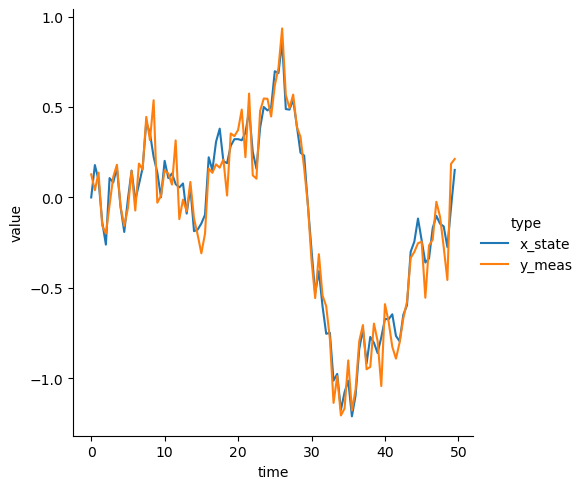

In [3]:
# parameter values
mu = 0.
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

### Calculate Particle Filter Marginal Logikelihood

For this we will use the basic particle filter provided by `pfjax.particle_filter()`.  We'll also compare the particle filter approximation $\hat{\ell}(\tth)$ to the exact loglikelihood $\ell(\tth)$ using "projection plots", i.e., we'll plot the one-dimensional marginal loglikelihood in each of the parameters $\tth = (\mu, \sigma, \tau)$ with the other two parameters fixed at their simulated values.  

- Projection plots are obtained with the help of the **projplot** package.
- Projection plots involve a fairly large number of evaluations of $\hat{\ell}(\tth)$, which itself involes $\bO(TN)$ evaluations of the state-space model functions $f(\xx_t \mid \xx_{t-1}, \tth)$ and $g(\yy_t \mid \xx_t, \tth)$.  We will therefore employ the JIT compilation engine offered by **JAX** to massively speed up function evaluations.
- We'll first create helper functions to evaluate the loglikelihoods which vectorize over multiple parameter values at once.  In particular, this allows us to easily specify a different PRNG key for each evaluation of $\hat{\ell}(\tth)$.

627 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
980 µs ± 9.48 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


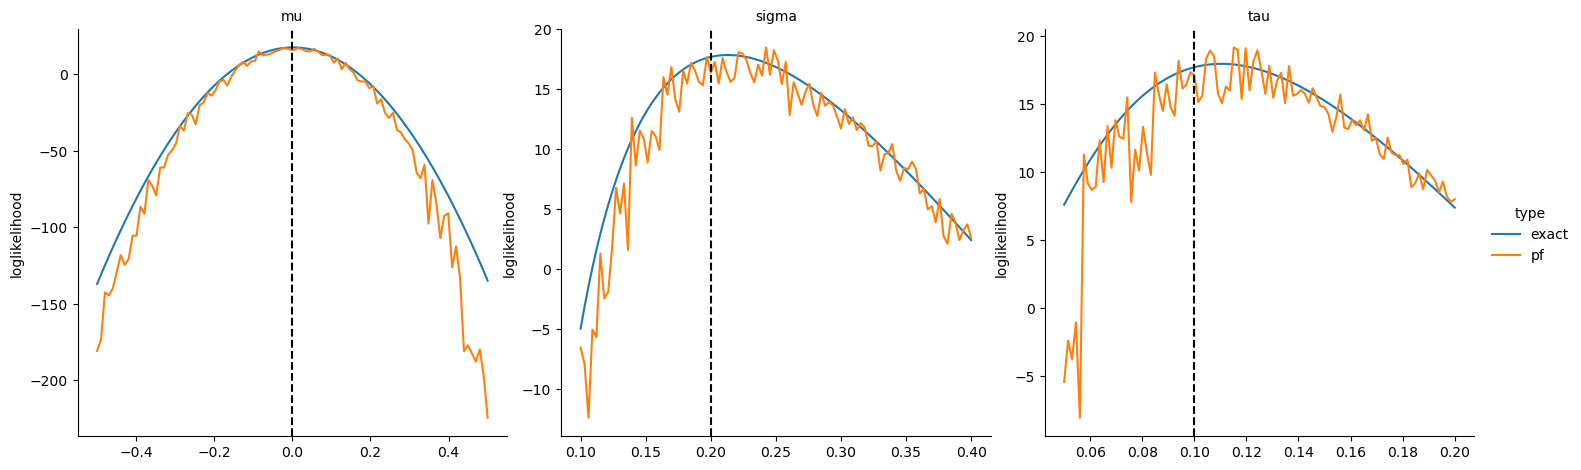

In [4]:
# particle filter specification
n_particles = 200  # number of particles


def bm_loglik_pf_nojit(theta, key):
    """
    Particle filter loglikelihood of the BM model (un-jitted).
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)


# jitted version
bm_loglik_pf_jit = jax.jit(bm_loglik_pf_nojit)

# check jit speedup
key, subkey = jax.random.split(key)
%timeit bm_loglik_pf_nojit(theta=theta_true, key=subkey)
%timeit bm_loglik_pf_jit(theta=theta_true, key=subkey)


@jax.jit
def bm_loglik_exact(theta):
    """
    Exact loglikelihood of the BM model (jitted).
    """
    theta = jnp.atleast_2d(theta)
    return jax.vmap(lambda _theta: bm_model.exact_lpdf(
        theta=_theta,
        y_meas=y_meas
    ))(theta)

# projection plot specification
n_pts = 100  # number of evaluation points per plot
# plot limits for each parameter
theta_lims = jnp.array([[-.5, .5], [.1, .4], [.05, .2]])
theta_names = ["mu", "sigma", "tau"]  # parameter names

# calculate projection plot for exact loglikelihood
df_exact = pjp.proj_plot(
    fun=bm_loglik_exact,
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_pf = pjp.proj_plot(
    fun=partial(bm_loglik_pf_jit, key=subkey),
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# merge data frames and plot them
plot_df = pd.concat([df_exact, df_pf], ignore_index=True)
plot_df["type"] = np.repeat(["exact", "pf"], len(df_exact["variable"]))
plot_df = plot_df.rename(columns={"y": "loglikelihood"})
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="loglikelihood",
    hue="type",
    col="variable",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(rp.axes.flat, theta_true):
    ax.axvline(theta, linestyle="--", color="black")

### Conclusions

- Jitting the particle filter computation offers almost a 1000x speed improvement!
- We see that the particle filter loglikelihood approximation is very accurate.  However, it seems to be increasingly biased as we move away from the true parameter value (dashed vertical lines).  This is likely because the quality of the bootstrap filter deteriorates considerably when this happens.

## Ideal Proposal with Noise (Non-Bootstrap Particle Filter)

Generally, the **ideal proposal** for the BM model is given by

$$
\begin{aligned}
q(x_0 \mid \tth) & = p(x_0 \mid y_0, \tth) = \frac{p(x_0, y_0 \mid \tth)}{p(y_0 \mid \tth)} = \frac{\pi(x_0 \mid \tth) p(y_0 \mid x_0, \tth)}{p(y_0 \mid \tth)}, \\
q(x_{t} \mid x_{t-1}, \tth) &= p(x_t \mid x_{t-1}, y_t, \tth) = \frac{p(x_t, y_t \mid x_{t-1}, \tth)}{p(y_t \mid x_{t-1}, \tth)} = \frac{p(y_t \mid x_t, \tth) p(x_t \mid x_{t-1}, \tth)}{p(y_t \mid \tth)}.
\end{aligned}
$$

where $p(y_t \mid x_{t-1}, \tth) = p(y_t \mid \tth)$ is due to the Markov property of the state-space model.

For the BM model we know the analytic expression of $p(y_t \mid \tth)$, which is a Normal distribution with mean and variance given by $\tilde \mu t$ and $\tilde \sigma^2 (1 + t) + \tau^2$, respectively (see [here](#bm_deriv) for a general derivation).

$p(y_t \mid x_{t-1}, \tth)$ is just a normalizing constant which should not essentially affect our proposal sampling of $x_t$ at each step.

Then we can set a **non-Bootstrap particle filter** using the ideal proposal 
<!-- perturbed by a systematic noise $\eps$ or a tiny independent random noise $\eps\N(0,1)$, -->

$$
\begin{aligned}
q(\xx_0 \mid \tth) & = \frac{\N(0, \sigma^2 \dt)\N(x_0, \tau^2)}{p(y_0 \mid \tth)},\\
q(\xx_{t} \mid \xx_{t-1}, \tth) &= \frac{\N(x_t, \tau^2) \N(x_{t-1} + \mu \dt, \sigma^2 \dt)}{p(y_t \mid \tth)} \\
\end{aligned}
$$

We notice that

$$
\begin{aligned}
\frac{\N(x_t, \tau^2) \N(x_{t-1} + \mu \dt, \sigma^2 \dt)}{p(y_t \mid \tth)} 
&\propto \exp\left( -\frac{(y_t - x_t)^2}{2\tau^2} - \frac{(x_t - x_{t-1} - \mu\dt)^2}{2\sigma^2\dt}  \right) \\ 
&\propto \exp\left(-\left(\frac{1}{2\tau^2} + \frac{1}{2\sigma^2\dt} \right)x_t^2 + \left(\frac{y_t}{\tau^2} + \frac{x_{t-1} + \mu\dt}{\sigma^2\dt} \right)x_t + C \right) \\
&\propto \exp\left(-A\left(x_t - \frac{B}{2A} \right)^2\right) = \N\left(\frac{B}{2A}, \frac{1}{2A} \right)
\end{aligned}
$$

where $A = \frac{1}{2\tau^2} + \frac{1}{2\sigma^2\dt}$, $B = \frac{y_t}{\tau^2} + \frac{x_{t-1} + \mu\dt}{\sigma^2\dt}$. Similarly,

$$
\begin{aligned}
\frac{\N(0, \sigma^2 \dt)\N(x_0, \tau^2)}{p(y_0 \mid \tth)} &\propto \exp\left(-\left(\frac{1}{2\tau^2} + \frac{1}{2\sigma^2\dt}\right) x_0^2 + \frac{y_0}{\tau^2} x_0 \right) \\
&\propto \exp\left(-A_0 \left(x_0 - \frac{B_0}{2A_0}\right)^2 \right)
\end{aligned}
$$
where $A_0 = \frac{1}{2\tau^2} + \frac{1}{2\sigma^2\dt}$, $B_0 = \frac{y_0}{\tau^2}$.

This relationship reveals how to sample $x_t$ at each step from the ideal proposal.

### Two ways to define a customized PF

Here we provide two ways to customize the BM model with the ideal proposal.

   1. Define individually the following member functions within the BM model class:
       - `init_{lpdf/sample}` for $x_0$ to calculate the log probability density / to draw the state varible from the initial proposal at time `t=0`. 
       - `step_{lpdf/sample}` for $x_t$ (`t=1,2,...`) to calculate the log probability density of the proposal distribution / to sample from the proposal.
       
   
   2. Define `pf_{init/step}` function in the BM model class (which overrides the same function in the base model class) to calculate the initial / general step of particle filter update, i.e. to return a draw from the proposal distribution.
   
Now the first way to define the model is shown as follows:

In [5]:
class BMModel_nBPF1(pf.BaseModel):

    def __init__(self, dt):
        """
        Class constructor.

        Args:
            dt: JAX scalar specifying the interobservation time.
            err: additional error term to the ideal proposal
        """
        super().__init__(bootstrap=False)  # Sets up a non-bootstrap filter
        self._dt = dt
#         self._err = err
        
    def init_lpdf(self, x_init, y_init, theta):
        """
        Calculate the log-density of the initial proposal for the state variable at time `t=0`.
        """
#         scale = theta[1] * jnp.sqrt(self._dt)
#         return jnp.log(jsp.stats.norm.pdf(x_init, loc=0.0, scale=scale) + self._err)
        A = 1/(2.0 * theta[2] * theta[2]) + 1/(2.0 * theta[1] * theta[1] * self._dt)
        B = y_init / (theta[2] * theta[2])
        return jsp.stats.norm.logpdf(x_init, loc=B/(2.0*A), scale=jnp.sqrt(1/(2.0 * A)))
        
    def init_sample(self, key, y_init, theta):
        """
        Sample one draw state variable from the initial proposal distribution at time `t=0`.
        """
#         scale = theta[1] * jnp.sqrt(self._dt)
        A = 1/(2.0 * theta[2] * theta[2]) + 1/(2.0 * theta[1] * theta[1] * self._dt)
        B = y_init / (theta[2] * theta[2])
#         return scale * jax.random.normal(key=key) + self._err * jax.random.normal(key=2*key)
        return B/(2.0 * A) + jnp.sqrt(1/(2.0 * A)) * jax.random.normal(key=key) #+ self._err * jax.random.normal(key=2*key)
    
    def step_lpdf(self, x_curr, x_prev, y_curr, theta):
        """
        Calculate log-density of the proposal distribution
        """
#         loc_prev = x_prev + theta[0] * self._dt
#         scale = theta[1] * jnp.sqrt(self._dt)
#         lpdf_ans = jsp.stats.norm.logpdf(x_curr, loc = loc_prev, scale = scale)
#         lpdf_ans += jsp.stats.norm.logpdf(y_curr, loc = x_curr, scale = theta[2])
#         sigma2_tilde = theta[1] * theta[1] * self._dt
#         tau2 = theta[2] * theta[2]
#         lpdf_ans -= jsp.stats.norm.logpdf(y_curr, loc = loc_prev, scale = jnp.sqrt(sigma2_tilde + tau2))
        A = 1/(2.0 * theta[2] * theta[2]) + 1/(2.0 * theta[1] * theta[1] * self._dt)
        B = y_curr / (theta[2] * theta[2]) + (x_prev + theta[0] * self._dt) / (theta[1] * theta[1] * self._dt)
        lpdf_ans = jsp.stats.norm.logpdf(x_curr, loc = B/(2.0 * A), scale = jnp.sqrt(1/(2.0 * A)))
#         return jnp.log(jnp.exp(lpdf_ans) + self._err) # self._err only adds constant to the logpdf
        return lpdf_ans
    
    def step_sample(self, key, x_prev, y_curr, theta):
        """
        Sample from the proposal distribution
        """
        A = 1/(2.0 * theta[2] * theta[2]) + 1/(2.0 * theta[1] * theta[1] * self._dt)
        B = y_curr / (theta[2] * theta[2]) + (x_prev + theta[0] * self._dt) / (theta[1] * theta[1] * self._dt)
        return B/(2.0 * A) + jnp.sqrt(1/(2.0 * A)) * jax.random.normal(key = key) #+ self._err * jax.random.normal(key=2*key)

    def prior_lpdf(self, x_init, theta):
        """
        Calculate the log-density of the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_init, loc=0.0, scale=scale)

    def prior_sample(self, key, theta):
        """
        Sample one draw from the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return scale * jax.random.normal(key=key)

    def state_lpdf(self, x_curr, x_prev, theta):
        """
        Calculate the log-density of the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = x_prev + theta[0] * self._dt
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_curr, loc=loc, scale=scale)

    def state_sample(self, key, x_prev, theta):
        """
        Sample one draw from the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = x_prev + theta[0] * self._dt
        scale = theta[1] * jnp.sqrt(self._dt)
        return loc + scale * jax.random.normal(key=key)

    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        Calculate the log-density of the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return jsp.stats.norm.logpdf(y_curr, loc=loc, scale=scale)

    def meas_sample(self, key, x_curr, theta):
        """
        Sample one draw from the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return loc + scale * jax.random.normal(key=key)

    def exact_lpdf(self, y_meas, theta):
        """
        Calculate exact log-density of measurement variables at times `t=0:T`.
        """
        mu_tilde = theta[0] * self._dt
        sigma2_tilde = theta[1] * theta[1] * self._dt
        tau2 = theta[2] * theta[2]
        n_obs = y_meas.shape[0]  # number of observations
        t_meas = jnp.arange(n_obs)
        mu_y = mu_tilde * t_meas  # mean of y_meas
        # variance of y_meas
        Sigma_y = sigma2_tilde * \
            jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas)
        Sigma_y = Sigma_y + sigma2_tilde
        Sigma_y = Sigma_y + tau2 * jnp.eye(n_obs)
        return jsp.stats.multivariate_normal.logpdf(
            x=y_meas, mean=mu_y, cov=Sigma_y
        )

Then the second way to define the same model is given below. For the general calculation of particle weights, please refer to [Introduction to PFJAX](https://pfjax.readthedocs.io/en/latest/notebooks/pfjax.html).

For the ideal proposal PF,

   - At `t=0`, 
   $$
   w_0 = \frac{\pi(x_0 \mid \theta)p(y_0 \mid x_0, \theta)}{q(x_0 \mid \theta)} = p(y_0 \mid \theta).
   $$
    
   - At `t=1,2,...`, 
   $$
   w_t = \frac{p(y_t \mid x_t, \theta) p(x_t \mid \tilde{x}_{t-1}, \theta)}{q(x_t \mid \tilde{x}_{t-1}, \theta)} = p(y_t \mid \tilde{x}_{t-1}, \theta)
   $$

In [6]:
class BMModel_nBPF2(pf.BaseModel):

    def __init__(self, dt):
        """
        Class constructor.

        Args:
            dt: JAX scalar specifying the interobservation time.
        """
        super().__init__(bootstrap=False)  # Sets up a non-bootstrap filter
        self._dt = dt
    
    def exact_lpdf(self, y_meas, theta):
        """
        Calculate exact log-density of measurement variables at times `t=0:T`.
        """
        mu_tilde = theta[0] * self._dt
        sigma2_tilde = theta[1] * theta[1] * self._dt
        tau2 = theta[2] * theta[2]
        n_obs = y_meas.shape[0]  # number of observations
        t_meas = jnp.arange(n_obs)
        mu_y = mu_tilde * t_meas  # mean of y_meas
        # variance of y_meas
        Sigma_y = sigma2_tilde * \
            jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas)
        Sigma_y = Sigma_y + sigma2_tilde
        Sigma_y = Sigma_y + tau2 * jnp.eye(n_obs)
        return jsp.stats.multivariate_normal.logpdf(
            x=y_meas, mean=mu_y, cov=Sigma_y
        )
    
    def pf_init(self, key, y_init, theta):
        r"""
        Initial step of particle filter.
        Returns a draw from the proposal distribution
        ::
            x_init ~ q(x_init) = p(x_init | y_init, theta)
        and calculates the log weight
        ::
            logw = log p(y_init | x_init, theta) + log p(x_init | theta) - log q(x_init)
        Args:
            key: PRNG key.
            y_init: Measurement variable at initial time `t = 0`.
            theta: Parameter value.
        Returns:
            Tuple:
            - **x_init** - A sample from the proposal distribution at initial tme `t = 0`.
            - **logw** - The log-weight of `x_init`.
        """
        A = 1/(2.0 * theta[2] * theta[2]) + 1/(2.0 * theta[1] * theta[1] * self._dt)
        B = y_init / (theta[2] * theta[2])
        x_init = B/(2.0 * A) + jnp.sqrt(1/(2.0 * A)) * jax.random.normal(key=key)
#         logw = jsp.stats.norm.logpdf(y_init, loc=x_init, scale=theta[2]) 
#         logw += jsp.stats.norm.logpdf(x_init, loc=0.0, scale=theta[1] * jnp.sqrt(self._dt))
#         logw -= jsp.stats.norm.logpdf(x_init, loc=B/(2.0*A), scale=jnp.sqrt(1/(2.0 * A)))
        # equivalently p(y_init | theta)
        logw = jsp.stats.norm.logpdf(y_init, loc = 0, 
                                     scale = jnp.sqrt((theta[1]*theta[1]*self._dt + theta[2]*theta[2])))
        return x_init, logw
        
        
    def pf_step(self, key, x_prev, y_curr, theta):
        r"""
        Particle filter update.
        Returns a draw from proposal distribution
        ::
            x_curr ~ q(x_curr) = q(x_curr | x_prev, y_curr, theta)
        and the log weight
        ::
            logw = log p(y_curr | x_curr, theta) + log p(x_curr | x_prev, theta) - log q(x_curr)
        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.
        Returns:
            Tuple:
            - **x_curr** - A sample from the proposal distribution at current time `t`.
            - **logw** - The log-weight of `x_curr`.
        """
        A = 1/(2.0 * theta[2] * theta[2]) + 1/(2.0 * theta[1] * theta[1] * self._dt)
        B = y_curr / (theta[2] * theta[2]) + (x_prev + theta[0] * self._dt) / (theta[1] * theta[1] * self._dt)
        x_curr = B/(2.0 * A) + jnp.sqrt(1/(2.0 * A)) * jax.random.normal(key = key) 
#         logw = jsp.stats.norm.logpdf(y_curr, loc=x_curr, scale=theta[2])
#         logw += jsp.stats.norm.logpdf(x_curr, loc=x_prev + theta[0] * self._dt, scale=theta[1] * jnp.sqrt(self._dt))
#         lp_prop = jsp.stats.norm.logpdf(x_curr, loc = B/(2.0 * A), scale = jnp.sqrt(1/(2.0 * A)))
#         logw -= lp_prop
        # equivalently p(y_curr | x_prev, theta)
        mu_tilde = theta[0] * self._dt
        sigma2_tilde = theta[1] * theta[1] * self._dt
        tau2 = theta[2] * theta[2]
        loc_prev = x_prev + mu_tilde
        logw = jsp.stats.norm.logpdf(y_curr, loc = loc_prev, scale = jnp.sqrt(sigma2_tilde + tau2))
        return x_curr, logw
        

### Simulate data

We can then simulate the same data using the same random `key` and the customized BM model with the same parameters.

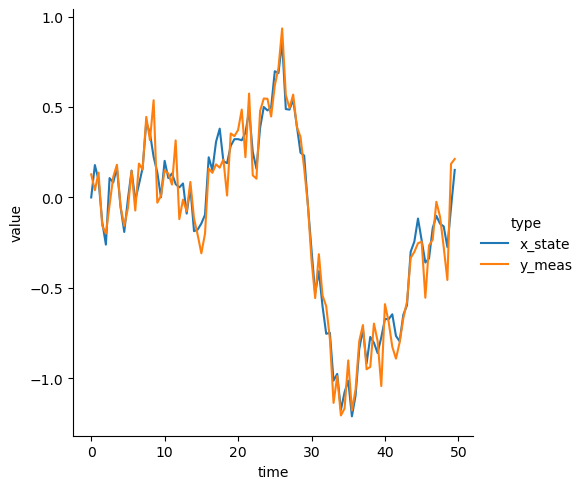

In [7]:
# parameter values
mu = 0.
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
# err = 0.0
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model_nbpf1 = BMModel_nBPF1(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model_nbpf1,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

### Calculate Particle Filter Marginal Logikelihood

For this we will use the built-in particle filter provided by `pfjax.particle_filter()`.  We'll also compare the particle filter approximation $\hat{\ell}(\tth)$ to the exact loglikelihood $\ell(\tth)$ using "projection plots", i.e., we'll plot the one-dimensional marginal loglikelihood in each of the parameters $\tth = (\mu, \sigma, \tau)$ with the other two parameters fixed at their simulated values.  


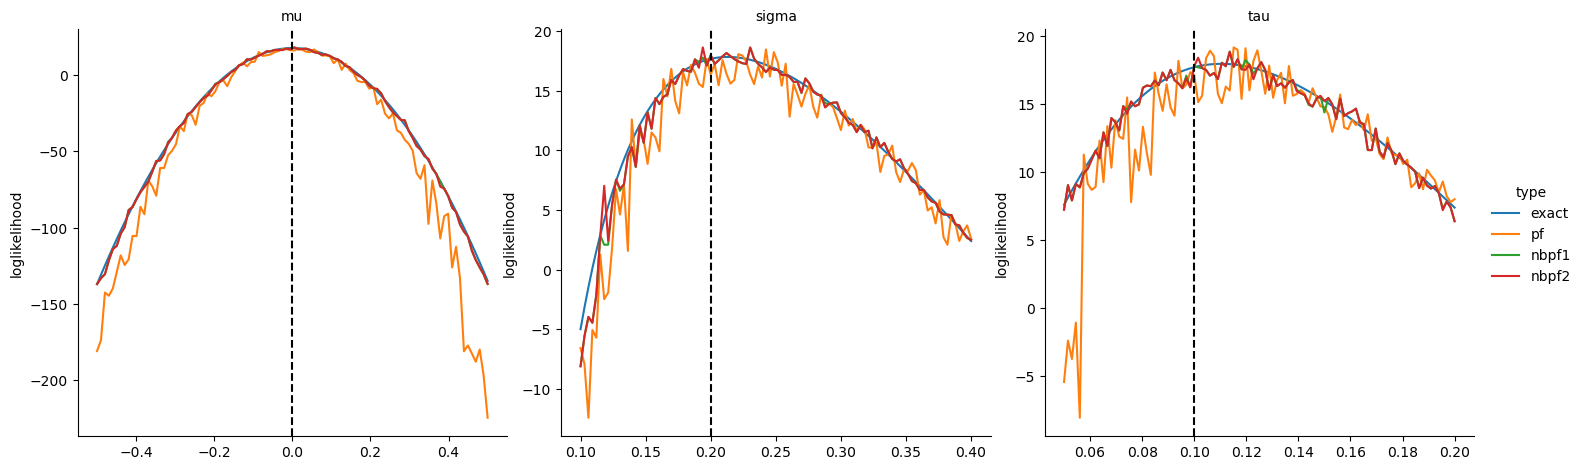

In [8]:
# particle filter specification
n_particles = 200  # number of particles

# The first way to define the customized BM model
def bm_loglik_pf_nojit1(theta, key):
    """
    Particle filter loglikelihood of the BM model (un-jitted).
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model_nbpf1,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

# jitted version
bm_loglik_pf_jit1 = jax.jit(bm_loglik_pf_nojit1)

# calculate projection plot for particle filter loglikelihood
df_pf1 = pjp.proj_plot(
    fun=partial(bm_loglik_pf_jit1, key=subkey),
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# The second way to define the customized BM model
bm_model_nbpf2 = BMModel_nBPF2(dt=dt)

def bm_loglik_pf_nojit2(theta, key):
    """
    Particle filter loglikelihood of the BM model (un-jitted).
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model_nbpf2,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

# jitted version
bm_loglik_pf_jit2 = jax.jit(bm_loglik_pf_nojit2)

# calculate projection plot for particle filter loglikelihood
df_pf2 = pjp.proj_plot(
    fun=partial(bm_loglik_pf_jit2, key=subkey),
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# merge data frames and plot them for comparison (cmp)
# pf: Bootstrap PF (default BM Model)
# nbpf1: non-Bootstrap PF with method 1 (customized BM model)
# nbpf2: non-Bootstrap PF with method 2 (customized BM model)
plot_df_cmp = pd.concat([df_exact, df_pf, df_pf1, df_pf2], ignore_index=True)
plot_df_cmp["type"] = np.repeat(["exact", "pf", "nbpf1", "nbpf2"], len(df_exact["variable"]))
plot_df_cmp = plot_df_cmp.rename(columns={"y": "loglikelihood"})
rp = sns.relplot(
    data=plot_df_cmp, kind="line",
    x="x", y="loglikelihood",
    hue="type",
    col="variable",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(rp.axes.flat, theta_true):
    ax.axvline(theta, linestyle="--", color="black")

### Conclusion

- The two different customized BM models with non-Bootstrap PF give exactly the same result.

- The ideal proposal gives better result than the default Bootstrap proposal. 

## (Old) OU Model with Measurement Errors (Another non-Bootstrap PF model)

Suppose the model is

$$
\begin{aligned}
x_0 & \sim \N(0, \sigma^2 \dt) \\
x_t & \sim \N(x_{t-1} - \mu x_{t-1} \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2).
\end{aligned}
$$

The parameters of the model are $\tth = (\mu, \sigma, \tau)$ with $\mu, \sigma, \tau > 0$.  Since $(\xx_{0:T}, \yy_{0:T})$ are jointly normal given $\tth$, we can show that $\yy_{0:T}$ is multivariate normal with mean and covariance 

$$
\begin{aligned}
E[y_t \mid \tth] & = E[E[x_t \mid x_0, \tth]] = E[x_0 e^{-\tilde\mu t}] = 0, \\ 
\cov(y_s, y_t) & = \frac{\sigma^2}{2\mu} e^{-\tilde\mu|t-s|} + \tau^2 \delta_{st},
\end{aligned}
$$

where $\tilde \mu = \mu \dt$, and $\delta_{st}$ is the indicator function.  These formulas provide an analytic expression for $\Ell(\tth) = p(\yy_{0:T} \mid \tth)$, which we can use to benchmark our calculations.

For a **non-Bootstrap particle filter**, we can set proposal distribution $q(\xx_0 \mid \tth)$ and $q(\xx_{t} \mid \xx_{t-1}, \tth)$, respectively as 

$$
\begin{aligned}
q(\xx_0 \mid \tth) & = \N(0, 1), \\
q(\xx_{t} \mid \xx_{t-1}, \tth) &= \N(x_{t-1}, \sigma^2 \dt).
\end{aligned}
$$

Clearly, the non-Bootstrap PF proposal is very naive, and may not be the optimal in terms of minimizing the predication variance. We should expect more number of particles needed to better fit the model.

In [ ]:
class OUModel(pf.BaseModel):

    def __init__(self, dt):
        """
        Class constructor.

        Args:
            dt: JAX scalar specifying the interobservation time.
        """
#         super().__init__(bootstrap=True)  # Sets up a bootstrap filter
        super().__init__(bootstrap=False)  # Sets up a non-bootstrap filter
        self._dt = dt
        
    def init_lpdf(self, x_init, y_init, theta):
        """
        Calculate the log-density of the initial proposal for the state variable at time `t=0`.
        """
        return jsp.stats.norm.logpdf(x_init, loc=0.0, scale=1.0)
        
    def init_sample(self, key, y_init, theta):
        """
        Sample one draw state variable from the initial proposal distribution at time `t=0`.
        """
        return 1.0 * jax.random.normal(key=key)
    
    def step_lpdf(self, x_curr, x_prev, y_curr, theta):
        """
        Calculate log-density of the proposal distribution
        """
        loc = x_prev
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_curr, loc = loc, scale = scale)
    
    def step_sample(self, key, x_prev, y_curr, theta):
        """
        Sample from the proposal distribution
        """
        loc = x_prev
        scale = theta[1] * jnp.sqrt(self._dt)
        return loc + scale * jax.random.normal(key=key)

    def prior_lpdf(self, x_init, theta):
        """
        Calculate the log-density of the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_init, loc=0.0, scale=scale)

    def prior_sample(self, key, theta):
        """
        Sample one draw from the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return scale * jax.random.normal(key=key)

    def state_lpdf(self, x_curr, x_prev, theta):
        """
        Calculate the log-density of the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = (1 - theta[0] * self._dt) * x_prev
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_curr, loc=loc, scale=scale)

    def state_sample(self, key, x_prev, theta):
        """
        Sample one draw from the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = (1 - theta[0] * self._dt) * x_prev
        scale = theta[1] * jnp.sqrt(self._dt)
        return loc + scale * jax.random.normal(key=key)

    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        Calculate the log-density of the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return jsp.stats.norm.logpdf(y_curr, loc=loc, scale=scale)

    def meas_sample(self, key, x_curr, theta):
        """
        Sample one draw from the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return loc + scale * jax.random.normal(key=key)

    def exact_lpdf(self, y_meas, theta):
        """
        Calculate exact log-density of measurement variables at times `t=0:T`.
        """
        mu_tilde = theta[0] * self._dt
#         sigma2_tilde = theta[1] * theta[1] * self._dt
        mu = theta[0]
        sigma2 = theta[1] * theta[1]
        tau2 = theta[2] * theta[2]
        n_obs = y_meas.shape[0]  # number of observations
        t_meas = jnp.arange(n_obs)
        mu_y = jnp.zeros(n_obs)  # mean of y_meas
        # variance of y_meas
        Sigma_y = jax.vmap(lambda t: jnp.abs(t - t_meas))(t_meas)
        Sigma_y = jnp.exp(- mu_tilde * Sigma_y)
#         Sigma_y = sigma2_tilde / (2*mu_tilde) * Sigma_y
        Sigma_y = sigma2 / (2*mu) * Sigma_y
        Sigma_y = Sigma_y + tau2 * jnp.eye(n_obs)
        return jsp.stats.multivariate_normal.logpdf(
            x=y_meas, mean=mu_y, cov=Sigma_y
        )

### Simulate Data

This is accomplished with the function `pfjax.simulate()`. The procedure is essentially the same as what we did in the BMModel example.

In [ ]:
# parameter values
mu = 0.4
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
ou_model = OUModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=ou_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

### Calculate Particle Filter Marginal Logikelihood

We can use the built-in particle filter provided by `pfjax.particle_filter()`.  We'll also compare the particle filter approximation $\hat{\ell}(\tth)$ to the exact loglikelihood $\ell(\tth)$ using "projection plots", i.e., we'll plot the one-dimensional marginal loglikelihood in each of the parameters $\tth = (\mu, \sigma, \tau)$ with the other two parameters fixed at their simulated values.

In [ ]:
# particle filter specification
n_particles = 200  # number of particles


def ou_loglik_pf_nojit(theta, key):
    """
    Particle filter loglikelihood of the OU model (un-jitted).
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=ou_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)


# jitted version
ou_loglik_pf_jit = jax.jit(ou_loglik_pf_nojit)

# check jit speedup
key, subkey = jax.random.split(key)
%timeit ou_loglik_pf_nojit(theta=theta_true, key=subkey)
%timeit ou_loglik_pf_jit(theta=theta_true, key=subkey)


@jax.jit
def ou_loglik_exact(theta):
    """
    Exact loglikelihood of the OU model (jitted).
    """
    theta = jnp.atleast_2d(theta)
    return jax.vmap(lambda _theta: ou_model.exact_lpdf(
        theta=_theta,
        y_meas=y_meas
    ))(theta)

# projection plot specification
n_pts = 100  # number of evaluation points per plot
# plot limits for each parameter
theta_lims = jnp.array([[0, 1.0], [.05, .5], [.05, .2]])
theta_names = ["mu", "sigma", "tau"]  # parameter names

# calculate projection plot for exact loglikelihood
df_exact = pjp.proj_plot(
    fun=ou_loglik_exact,
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_pf = pjp.proj_plot(
    fun=partial(ou_loglik_pf_jit, key=subkey),
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# merge data frames and plot them
plot_df = pd.concat([df_exact, df_pf], ignore_index=True)
plot_df["type"] = np.repeat(["exact", "pf"], len(df_exact["variable"]))
plot_df = plot_df.rename(columns={"y": "loglikelihood"})
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="loglikelihood",
    hue="type",
    col="variable",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(rp.axes.flat, theta_true):
    ax.axvline(theta, linestyle="--", color="black")

<a id="bm_deriv"></a>
## Appendix: Exact Likelihood of the BM Model

The distribution of $p(\xx_{0:T}, \yy_{0:T} \mid \tth)$ is multivariate normal.  Thus, $p(\yy_{0:T} \mid \tth)$ is also multivariate normal, and we only need to find $E[y_t \mid \tth]$ and $\cov(y_s, y_t \mid \tth)$.

Conditioned on $x_0$ and $\tth$, the Brownian latent variables $\xx_{1:T}$ are multivariate normal with

$$
\newcommand{\cov}{\operatorname{cov}}
\begin{aligned}
E[x_t \mid x_0, \tth] & = x_0 + \tilde \mu t, \\
\cov(x_s, x_t \mid x_0, \tth) & = \tilde \sigma^2 \min(s, t),
\end{aligned}
$$

where $\tilde \mu = \mu \dt$ and $\tilde \sigma^2 = \sigma^2 \dt$.

Therefore, $p(\xx_{0:T} \mid \tth)$ is multivariate normal with

$$
\begin{aligned}
E[x_t \mid \tth] & = E[E[x_t \mid x_0, \tth]] \\
& = \tilde \mu t, \\
\cov(x_s, x_t \mid \tth) & = \cov(E[x_s \mid x_0, \tth], E[x_t \mid x_0, \tth]) + E[\cov(x_s, x_t \mid x_0, \tth)] \\
& = \tilde \sigma^2 (1 + \min(s, t)).
\end{aligned}
$$

Similarly, conditioned on $\xx_{0:T}$ and $\tth$, the measurement variables $\yy_{0:T}$ are multivariate normal with

$$
\begin{aligned}
E[y_t \mid \xx_{0:T}, \tth] & = x_t, \\
\cov(y_s, y_t \mid \xx_{0:T}, \tth) & = \tau^2 \delta_{st}.
\end{aligned}
$$

Therefore, $p(\yy_{0:T} \mid \tth)$ is multivariate normal with

$$
\begin{aligned}
E[y_t \mid \tth] & = \tilde \mu t, \\
\cov(y_s, y_t \mid \tth) & = 
% \cov(E[y_s \mid \xx_{0:T}, \tth], E[y_t \mid \xx_{0:T}, \tth]) + E[\cov(y_s, y_t \mid \xx_{0:T}, \tth)] \\
\tilde \sigma^2 (1 + \min(s, t)) + \tau^2 \delta_{st}.
\end{aligned}
$$

### TODO

- How to set up a customized proposal

- Different ways to set up particle filter (init_sample, step_sample, etc. vs pf_step function)

- For $x_0$: define init_sample/lpdf

- 

- Just compare the bootstrap PF plot and the ideal proposal plot


### TODO(OLD)

 - Compare different $\eps$ settings in an overlapped projection plot.
 
 - If time is allowed, we may later consider a nonlinear dynamic model
 
     $$
     \begin{aligned}
     X_n &= \alpha X_{n-1} + \beta \frac{X_{n-1}}{1 + X_{n-1}^2} + \gamma \cos(\omega n) + \sigma_x U_n, \\
     Y_n &= \eta X_n^2 + \sigma_y V_n
     \end{aligned}
     $$
     
     where $U_n, V_n \iid \N(0,1)$.
     